In [115]:
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno


# data 불러오기
socar_rd = pd.read_csv('datas/insurance_fraud_detect_data.csv')

In [2]:
socar_rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fraud_YN               16000 non-null  int64  
 1   car_model              16000 non-null  int64  
 2   sharing_type           16000 non-null  int64  
 3   age_group              16000 non-null  int64  
 4   has_previous_accident  16000 non-null  int64  
 5   cumulative_use_count   16000 non-null  int64  
 6   b2b                    16000 non-null  int64  
 7   accident_ratio         16000 non-null  int64  
 8   pf_type                16000 non-null  int64  
 9   socarpass              16000 non-null  int64  
 10  socarsave              16000 non-null  int64  
 11  start_hour             16000 non-null  int64  
 12  duration               16000 non-null  int64  
 13  accident_hour          16000 non-null  int64  
 14  repair_cost            16000 non-null  float64
 15  in

In [7]:
np.unique(socar_rd.test_set, return_counts=True)

(array([0, 1]), array([12879,  3121]))

# ===========================
### 전처리 반영 내용 (베이스라인, 비교군)
- hour 순서 바꿔놓기 (start , accident)
- duration 순서 바꿔놓기

- 데이터 손 아무것도 안대고 알고리즘별 결과 구하기 (베이스라인을 위해)  
  --> recall==0이라 oversampling하고 baseline잡아야 할듯
- 전체 스케일링&원핫인코딩 vs. 스케일링만(원핫인코딩 없이) vs.인코딩만(스케일링X)
- null값 행/열 제외 or 그대로 or 대치 (acci_hour==-1, acci_loc=5, acc_type==0,  
  insur_YN ==0, police_YN ==0, total_prsn_cnt==-1)
- gap 열 추가유무에 따른 차이 (알수없음은 대체값 삽입)
- ** imbalance 교정 방법 : SMOTE, (+ a?) **
### 사용할 ML 기법 및 절차 (분류)
- Logistic Regression
- RandomForest, DecisionTree
- lgbmboost
- naiveBaysian
- cluster (KNN) (고차원 불리하니 PCA가 선행 필요할 듯)
- (SVM)
- PCA
- cv

### 성능평가 기준
- recall, precision, f1score, (+ accuracy), roc_curve

### 고려할 만한 데이터 이상값
- start~acci gap이 duration을 고려했을 때 있을 수 없는 값들

### 데이터 수집 시 개선하면 좋을 사항들
- 시간을 범주화가 아니라 시간별 등 더 자세하게 & 하려면 일정 간격으로  
  (분석할 때는 유의미한 범주화겠지만, 모델링 시, 시간 갭을 보려할 때 범주 1개 차이의 의미가 달라질 수 있기 때문)
# ===========================

In [20]:
np.unique(socar_rd.start_hour), np.unique(socar_rd.accident_hour), \
np.unique(socar_rd.duration)

(array([1, 2, 3, 4, 5, 6]),
 array([-1,  1,  2,  3,  4,  5,  6]),
 array([1, 2, 3, 4, 5]))

In [19]:
# 전처리

In [116]:
# 헷갈리니 start_hour, duration, accident_hour 순서 순으로 다시 범주화
socar_rd_cp = socar_rd.copy()


# start_hour
socar_rd_cp["start_hour"].replace(2, 10, inplace=True) # 1은 21~04시 (변동X)
socar_rd_cp["start_hour"].replace(3, 2, inplace=True) # 2는 05~07시
socar_rd_cp["start_hour"].replace(4, 3, inplace=True) # 3은 8~10시
socar_rd_cp["start_hour"].replace(5, 4, inplace=True) # 4는 11~13시
socar_rd_cp["start_hour"].replace(6, 5, inplace=True) # 5는 14~16시
socar_rd_cp["start_hour"].replace(10, 6, inplace=True) # 6은 17~20시


# accident_hour
socar_rd_cp["accident_hour"].replace(2, 10, inplace=True) # 1은 21~04시 (변동X)
socar_rd_cp["accident_hour"].replace(3, 2, inplace=True) # 2는 05~07시
socar_rd_cp["accident_hour"].replace(4, 3, inplace=True) # 3은 8~10시
socar_rd_cp["accident_hour"].replace(5, 4, inplace=True) # 4는 11~13시
socar_rd_cp["accident_hour"].replace(6, 5, inplace=True) # 5는 14~16시
socar_rd_cp["accident_hour"].replace(10, 6, inplace=True) # 6은 17~20시


# duration
socar_rd_cp["duration"].replace(5, 10, inplace=True) # 1은 0~1시간대
socar_rd_cp["duration"].replace(4, 5, inplace=True) # 2는 2~5시간대
socar_rd_cp["duration"].replace(3, 4, inplace=True) # 3은 6~9시간대
socar_rd_cp["duration"].replace(2, 3, inplace=True) # 4는 10~36시간대
socar_rd_cp["duration"].replace(1, 2, inplace=True) # 5는 36시간 초과
socar_rd_cp["duration"].replace(10, 1, inplace=True)

In [117]:
# train, test dataset 구분
train_df = socar_rd_cp[socar_rd_cp.test_set==0]
test_df = socar_rd_cp[socar_rd_cp.test_set==1]

In [118]:
train_df.shape, test_df.shape

((12879, 25), (3121, 25))

In [119]:
# 구분했으니 test_set 열은 삭제
train_df.drop(["test_set"], axis=1, inplace=True)
test_df.drop(["test_set"], axis=1, inplace=True)

train_df.shape, test_df.shape

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


((12879, 24), (3121, 24))

In [22]:
# 데이터 넣으면 바로 각종 score 나오도록 함수 작성

In [120]:
# 각각 xlabel과 ylabel 구분
X_train = train_df.drop(["fraud_YN"], axis=1)
y_train = train_df["fraud_YN"]
X_test = test_df.drop(["fraud_YN"], axis=1)
y_test = test_df["fraud_YN"]

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)


clfs = [('LogisticRegression', LogisticRegression(random_state=13, solver='liblinear')),
      ('DecisionTree', DecisionTreeClassifier(random_state=13, max_depth=4)),
       ("RandomForest", RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)),
       ("LGBMBoost", LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)),
       ]

In [170]:
for name, model in clfs:
    print('============')
    print('name:', name)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print("accuracy_score:", accuracy_score(y_test, pred))
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))

name: LogisticRegression
accuracy_score: 0.9977571291252804
[[3114    0]
 [   7    0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3114
           1       0.00      0.00      0.00         7

    accuracy                           1.00      3121
   macro avg       0.50      0.50      0.50      3121
weighted avg       1.00      1.00      1.00      3121

name: DecisionTree
accuracy_score: 0.9977571291252804
[[3114    0]
 [   7    0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3114
           1       0.00      0.00      0.00         7

    accuracy                           1.00      3121
   macro avg       0.50      0.50      0.50      3121
weighted avg       1.00      1.00      1.00      3121

name: RandomForest


/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

accuracy_score: 0.9977571291252804
[[3114    0]
 [   7    0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3114
           1       0.00      0.00      0.00         7

    accuracy                           1.00      3121
   macro avg       0.50      0.50      0.50      3121
weighted avg       1.00      1.00      1.00      3121

name: LGBMBoost


/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

accuracy_score: 0.9977571291252804
[[3114    0]
 [   7    0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3114
           1       0.00      0.00      0.00         7

    accuracy                           1.00      3121
   macro avg       0.50      0.50      0.50      3121
weighted avg       1.00      1.00      1.00      3121



/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [44]:
np.unique(pred, return_counts=True)

(array([0, 1]), array([3105,   16]))

# -> imbalance 처리 안하니까 애초에 1을 예측하지 않음 -> baseline도 일단 imbalance는 해결한 다음 잡아야겠다

In [63]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([12845,    34]))

In [65]:
round(34 / len(y_train) * 100 ,2)

0.26

In [66]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([3114,    7]))

In [69]:
# 비율은 수업시간에 한 신용카드사기보다 높은데 왜 더 편향된 결과가 나오지?
round(7 / (3114+7) * 100,2)

0.22

In [70]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score)

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    
    return acc, pre ,re, f1, auc

In [71]:
def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)
    
    print("==> confusion matrix")
    print(confusion)
    print('=========')
    
    print('Accuracy: {0: .4f}, Precision: {1: .4f}'.format(acc, pre))
    print('Recall: {0: .4f}, F1: {1: .4f}, AUC:{2: .4f}'.format(re, f1, auc))

In [72]:
lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

print_clf_eval(y_test, lr_pred)

==> confusion matrix
[[3114    0]
 [   7    0]]
Accuracy:  0.9978, Precision:  0.0000
Recall:  0.0000, F1:  0.0000, AUC: 0.5000


/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,
                         boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
lgbm_pred = lgbm_clf.predict(X_test)

print_clf_eval(y_test, lgbm_pred)

==> confusion matrix
[[3114    0]
 [   7    0]]
Accuracy:  0.9978, Precision:  0.0000
Recall:  0.0000, F1:  0.0000, AUC: 0.5000


/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# imbalance 처리부터 하자...

In [121]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [122]:
X_train.shape, y_train.shape

((12879, 23), (12879,))

In [133]:
X_train_over.shape, y_train_over.shape

((25690, 23), (25690,))

In [134]:
np.unique(y_train, return_counts=True), np.unique(y_train_over, return_counts=True)

((array([0, 1]), array([12845,    34])),
 (array([0, 1]), array([12845, 12845])))

In [159]:
# 다시...! --> LR과 DT는 baseline나옴.. 0.29 (2/7). 어떻게든 2개 이상은 맞추는 것이 목표!
for name, model in clfs:
    print('============')
    print('name:', name)
    model.fit(X_train_over, y_train_over)
    pred = model.predict(X_test)
    print("accuracy_score:", accuracy_score(y_test, pred))
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))

name: LogisticRegression
accuracy_score: 0.7926946491509131
[[2472  642]
 [   5    2]]
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      3114
           1       0.00      0.29      0.01         7

    accuracy                           0.79      3121
   macro avg       0.50      0.54      0.45      3121
weighted avg       1.00      0.79      0.88      3121

name: DecisionTree
accuracy_score: 0.6529958346683755
[[2036 1078]
 [   5    2]]
              precision    recall  f1-score   support

           0       1.00      0.65      0.79      3114
           1       0.00      0.29      0.00         7

    accuracy                           0.65      3121
   macro avg       0.50      0.47      0.40      3121
weighted avg       1.00      0.65      0.79      3121

name: RandomForest
accuracy_score: 0.9967958987504005
[[3111    3]
 [   7    0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.0

In [164]:
lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train_over, y_train_over)

dt_clf = DecisionTreeClassifier(max_depth=4, random_state=13)
dt_clf.fit(X_train_over, y_train_over)

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)
rf_clf.fit(X_train_over, y_train_over)

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,
                         boost_from_average=False)
lgbm_clf.fit(X_train_over, y_train_over)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ["LogisticReg", "DecisionTree", 'RandomForest', 'LightGBM']

In [165]:
def draw_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(5,5))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[: ,1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label=model_names[model])
        
    plt.plot([0,1], [0,1], 'k--', label='random guess')
    plt.title("ROC")
    plt.legend()
    plt.grid()
    plt.show()

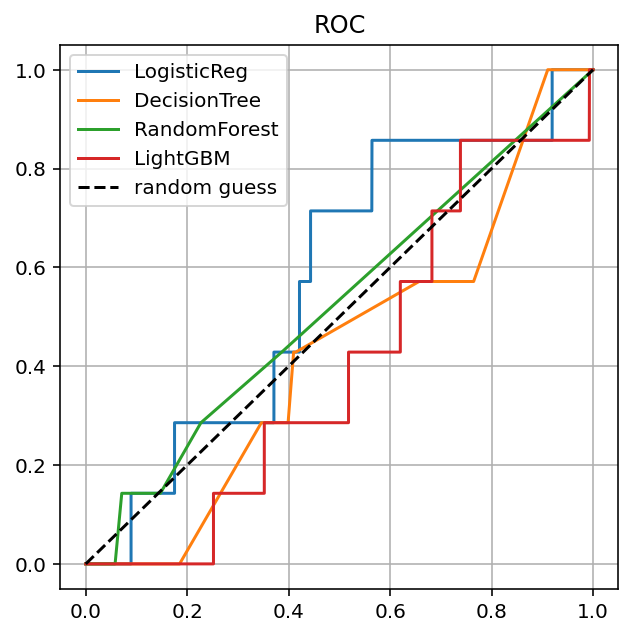

In [166]:
draw_roc_curve(models, model_names, X_test, y_test)

In [172]:
# imbalance SMOTE로 처리했지만 결과 LR이 그나마, 나머지는 여전히 별로.. 전처리가 필수일 것 같다.. 하나씩 전처리하면서 변화 확인하기